In [1]:
import tensorflow as tf
import numpy as np
import datetime
import json
import gzip
import matplotlib.pyplot as plt
import re
import os
import shutil
from tqdm import tqdm_notebook

In [2]:
sess = None

In [3]:
def reset_tf(sess = None, log_device_placement = False):
    if sess:
        sess.close()
    tf.reset_default_graph()
    tf.set_random_seed(0)
    return tf.InteractiveSession(config = tf.ConfigProto(log_device_placement = log_device_placement))

def dump_statistics():
    total_parameters = 0
    for variable in tf.trainable_variables():
        # shape is an array of tf.Dimension
        shape = variable.get_shape()
        variable_parameters = 1
        for dim in shape:
            variable_parameters *= dim.value
        print('parameters for "%s": %d' % (variable.name, variable_parameters))
        total_parameters += variable_parameters
    print('total parameters: %d' % total_parameters)

In [4]:
class HyperParameters:
    learning_rate = 1e-3
    
    vocab_size = 30000
    num_targets = 2000
    
    dropout_rate = 0.1
    
    context_size = 81
    
    d_embedding_position = 32
    d_embedding_word = 128
    
    d_attention = 128
    d_attention_ff = 512
    
    num_attention_heads = 2
    d_attention_head = d_attention // num_attention_heads
    
    attention_num_layers = 3

    dataset_batch_size = 512
    dataset_num_parallel_calls = 4
    dataset_prefetch_size = 4096
    dataset_shuffle_size = 4096
    
    gradient_clip_norm = 5.0

In [5]:
class EntityLinkingModel:
    def __init__(self, session, hp):
        self._session = session
        self._hp = hp
        
    def _parse_example(self, example_proto):
        parsed = tf.parse_single_example(example_proto, features = {
            'page_id': tf.FixedLenFeature([1], tf.int64),
            'target_id': tf.FixedLenFeature([1], tf.int64),
            'context_word_ids': tf.FixedLenFeature([self._hp.context_size], tf.int64),
            'link_mask': tf.FixedLenFeature([self._hp.context_size], tf.int64) })
        
#         # apply random crop
#         offset = tf.random_uniform(
#             [],
#             maxval = self._hp.input_context_size - self._hp.context_size,
#             dtype = tf.int32)
#
#         # apply croppings
#         context_word_ids = parsed['context_word_ids']
#         context_word_ids = context_word_ids[offset:offset + self._hp.context_size]
#         link_mask = parsed['link_mask']
#         link_mask = link_mask[offset:offset + self._hp.context_size]

        context_word_ids = parsed['context_word_ids']
        link_mask = parsed['link_mask']
        
        return (parsed['target_id'], context_word_ids, link_mask)

    def _build_data_pipeline(self):
        with tf.variable_scope('dataset'):
            # placeholders
            self._dataset_filenames = tf.placeholder(
                tf.string,
                shape = [None],
                name = 'dataset_filenames')
            self._dataset_limit = tf.placeholder_with_default(
                tf.constant(-1, tf.int64),
                shape = [],
                name = 'dataset_limit')
            self._dataset_shuffle_size = tf.placeholder_with_default(
                tf.constant(self._hp.dataset_batch_size, tf.int64),
                shape = [],
                name = 'dataset_shuffle_size')
            self._dataset_batch_size = tf.placeholder_with_default(
                tf.constant(self._hp.dataset_batch_size, tf.int64),
                shape = [],
                name = 'dataset_batch_size')
            self._dataset_prefetch_size = tf.placeholder_with_default(
                tf.constant(self._hp.dataset_prefetch_size, tf.int64),
                shape = [],
                name = 'dataset_prefetch_size')

            # build dataset
            dataset = tf.data.TFRecordDataset(
                tf.random_shuffle(self._dataset_filenames),
                compression_type='GZIP')
            dataset = dataset.take(self._dataset_limit)
            dataset = dataset.map(
                self._parse_example,
                num_parallel_calls = self._hp.dataset_num_parallel_calls)
            dataset = dataset.shuffle(self._dataset_shuffle_size)
            dataset = dataset.prefetch(self._dataset_prefetch_size)
            dataset = dataset.batch(self._dataset_batch_size)

            # build iterator
            self._dataset_iterator = dataset.make_initializable_iterator()
            (target_labels, context_word_ids, link_mask) = self._dataset_iterator.get_next()
            target_labels = tf.squeeze(target_labels, axis = -1)

            # give key tensors names
            self._context_word_ids = tf.identity(context_word_ids, 'context_word_ids')
            self._target_labels = tf.identity(target_labels, 'target_labels')
            self._link_mask = tf.identity(link_mask, 'link_mask')

            # minibatch size
            self._minibatch_size = tf.shape(self._context_word_ids)[0]
            self._minibatch_size = tf.identity(self._minibatch_size, 'minibatch_size')
            
            # positions
            p = tf.range(self._hp.context_size, dtype = tf.int64)
            p = tf.tile(p, [self._minibatch_size])
            p = tf.reshape(
                p,
                [self._minibatch_size, self._hp.context_size],
                name = 'context_positions')
            self._context_positions = p
            
    def _attention_layer(self, A, scope, reuse=None):
        with tf.variable_scope(scope, reuse=reuse):
            projection_weights = tf.get_variable(
                'projection_weights',
                [self._hp.num_attention_heads, self._hp.d_attention, self._hp.d_attention_head])
            output_weights = tf.get_variable(
                'output',
                [self._hp.d_attention, self._hp.d_attention])

            # compute each attention head
            heads = []
            for i in range(self._hp.num_attention_heads):\
                # project queries/keys/values
                Q_proj = tf.tensordot(A, projection_weights[i], axes = 1)
                K_proj = tf.tensordot(A, projection_weights[i], axes = 1)
                V_proj = tf.tensordot(A, projection_weights[i], axes = 1)
                # N.B., hint shapes since tensordot can't infer
                Q_proj.set_shape([None, self._hp.context_size, self._hp.d_attention_head])
                K_proj.set_shape([None, self._hp.context_size, self._hp.d_attention_head])
                V_proj.set_shape([None, self._hp.context_size, self._hp.d_attention_head])

                # compute attention for head
                K_proj_T = tf.transpose(K_proj, perm = [0, 2, 1])
                scaled_logits = tf.matmul(Q_proj, K_proj_T) / tf.sqrt(float(self._hp.d_attention_head))
                head = tf.matmul(tf.nn.softmax(scaled_logits), V_proj)
                heads.append(head)

            # concatenate heads
            result = tf.concat(heads, axis=-1)
            
            # transform by output weights
            result = tf.tensordot(result, output_weights, axes = 1)
            # N.B., hint shape since tensordot can't infer
            result.set_shape([None, self._hp.context_size, self._hp.d_attention])
            
            return result

    def _attention_ff_layer(self, A, scope, reuse=None):
        with tf.variable_scope(scope, reuse=reuse):
            A = tf.layers.dense(A, self._hp.d_attention_ff, activation=tf.nn.relu, name='fc1')
            A = tf.layers.dense(A, self._hp.d_attention, name='fc2')
            return A
    
    def _attention_full_layer(self, A, scope, reuse=None):
        with tf.variable_scope(scope, reuse=reuse):
            # attention (plus residual)
            A = self._attention_layer(A, 'attention', reuse) + A
            
            # post-attention batch norm
            A = tf.layers.batch_normalization(
                A, 
                training=self._training,
                name='attention',
                reuse=reuse)
            
            # post-attention dropout (_after_ batch norm)
            A = tf.layers.dropout(
                A, 
                rate=self._hp.dropout_rate, 
                training=self._training)
            
            # feed-forward (plus residual)
            A = self._attention_ff_layer(A, 'ff', reuse) + A
            
            # post-feed-forward batch norm
            A = tf.layers.batch_normalization(
                A,
                training=self._training,
                name='ff',
                reuse=reuse)
            
            # post-feed-forward dropout
            A = tf.layers.dropout(
                A, 
                rate=self._hp.dropout_rate, 
                training=self._training)
            
            return A
            
    def _build_model(self):
        with tf.variable_scope('model'):
            # placeholder: training flag
            self._training = tf.placeholder(tf.bool, name = 'training')
            
            # embed context words
            word_embeddings = tf.get_variable(
                'word_embeddings', 
                [self._hp.vocab_size, self._hp.d_embedding_word])
            context_words_embedded = tf.nn.embedding_lookup(
                word_embeddings,
                self._context_word_ids)

            # embed context positions
            position_embeddings = tf.get_variable(
                'position_embeddings',
                [self._hp.context_size, self._hp.d_embedding_position],
                dtype=tf.float32)
            context_positions_embedded = tf.nn.embedding_lookup(
                position_embeddings,
                self._context_positions)

            # build full context vector (concat embeddings)
            context_full = tf.concat(
                [context_words_embedded, context_positions_embedded], 
                axis=-1)
#             context_full = context_words_embedded + context_positions_embedded
            
            # build attention layers
            with tf.variable_scope('attention_with_ff'):
                # build input vector
                context_attention = tf.layers.dense(
                    context_full,
                    self._hp.d_attention,
                    activation=tf.nn.relu,
                    name='input')
                context_attention = tf.layers.batch_normalization(
                    context_attention,
                    training=self._training,
                    name='input')
                context_attention = tf.layers.dropout(
                    context_attention,
                    rate=self._hp.dropout_rate,
                    training=self._training)
                
                layer = context_attention
                for i in range(self._hp.attention_num_layers):
                    layer = self._attention_full_layer(layer, 'layer_%d' % i)

            # average the attention vectors for the link
            # TODO: combine these in a smarter way
            link_mask = tf.cast(self._link_mask, tf.float32)
            link_mask = tf.reshape(link_mask, [-1, self._hp.context_size, 1])
            layer *= link_mask
            layer = tf.reduce_sum(layer, axis = -2, keep_dims = True)
            layer /= tf.reduce_sum(link_mask, axis = -2, keep_dims = True)
            layer = tf.squeeze(layer, axis = -2)
            
            # build final softmax layer
            self._output_logits = tf.layers.dense(
                layer,
                self._hp.num_targets,
                name = 'softmax')

    def _build_training_model(self):
        with tf.variable_scope('train'):
            losses = tf.nn.sparse_softmax_cross_entropy_with_logits(
                labels = self._target_labels,
                logits = self._output_logits)
            
            self._total_loss = tf.reduce_sum(losses, name = 'total_loss')
            self._mean_loss = tf.reduce_mean(losses, name = 'mean_loss')
            
            # N.B., tf.nn.softmax here is unnecessary?
            output_labels = tf.argmax(tf.nn.softmax(self._output_logits), axis=-1)
            correct_labels = tf.cast(
                tf.equal(output_labels, self._target_labels), 
                tf.int32)
            self._output_labels = tf.identity(output_labels, name = 'output_labels')
            self._num_correct_labels = tf.reduce_sum(correct_labels, name = 'num_correct_labels')
            
            update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
            with tf.control_dependencies(update_ops):
                self._global_step = tf.Variable(0, name='global_step', trainable=False)
                self._optimizer = tf.train.AdamOptimizer(learning_rate=self._hp.learning_rate)
                
                # gradient clipping
                gradients, variables = zip(*self._optimizer.compute_gradients(self._mean_loss))
                gradients, _ = tf.clip_by_global_norm(
                    gradients, 
                    self._hp.gradient_clip_norm)
                
                self._train_op = self._optimizer.apply_gradients(
                    zip(gradients, variables),
                    global_step = self._global_step)
#                 self._train_op = self._optimizer.minimize(
#                     self._mean_loss,
#                     global_step=self._global_step)

    
    def build_model(self):
        self._build_data_pipeline()
        self._build_model()
        self._build_training_model()

    def process(self,
                dataset_filenames,
                dataset_limit = -1,
                header = 'results',
                train = False,
                log_file = None):
        # initialize dataset to files
        self._session.run(self._dataset_iterator.initializer, feed_dict={
            self._dataset_filenames: dataset_filenames,
            self._dataset_limit: dataset_limit })

        cum_loss = 0
        cum_num_examples = 0
        cum_correct_examples = 0
        
        start = datetime.datetime.now()
        progress = tqdm_notebook(leave = False, desc = header)

        while True:
            # process a minibatch
            try:
                (_,
                 curr_total_loss, 
                 curr_minibatch_size,
                 curr_num_correct_labels) = self._session.run(
                    (self._train_op if train else (),
                     self._total_loss,
                     self._minibatch_size,
                     self._num_correct_labels),
                    feed_dict = { self._training: train })
            except tf.errors.OutOfRangeError:
                break

            # update stats/progress
            cum_loss += curr_total_loss
            cum_num_examples += curr_minibatch_size
            cum_correct_examples += curr_num_correct_labels
            progress.update(curr_minibatch_size)

        progress.close()
        finish = datetime.datetime.now()

        # print/log output
        message = '%s: time=%s, step=%d, loss=%g, accuracy=%g' % (
            header,
            finish - start,
            tf.train.global_step(sess, self._global_step),
            cum_loss / cum_num_examples,
            cum_correct_examples / cum_num_examples)
        print(message)
        if log_file:
            print(message, file=log_file)
            log_file.flush()

In [6]:
sess = reset_tf(sess)

model = EntityLinkingModel(sess, HyperParameters())
model.build_model()
dump_statistics()

parameters for "model/word_embeddings:0": 3840000
parameters for "model/position_embeddings:0": 2592
parameters for "model/attention_with_ff/input/kernel:0": 20480
parameters for "model/attention_with_ff/input/bias:0": 128
parameters for "model/attention_with_ff/input/gamma:0": 128
parameters for "model/attention_with_ff/input/beta:0": 128
parameters for "model/attention_with_ff/layer_0/attention/projection_weights:0": 16384
parameters for "model/attention_with_ff/layer_0/attention/output:0": 16384
parameters for "model/attention_with_ff/layer_0/attention/gamma:0": 128
parameters for "model/attention_with_ff/layer_0/attention/beta:0": 128
parameters for "model/attention_with_ff/layer_0/ff/fc1/kernel:0": 65536
parameters for "model/attention_with_ff/layer_0/ff/fc1/bias:0": 512
parameters for "model/attention_with_ff/layer_0/ff/fc2/kernel:0": 65536
parameters for "model/attention_with_ff/layer_0/ff/fc2/bias:0": 128
parameters for "model/attention_with_ff/layer_0/ff/gamma:0": 128
paramete

In [7]:
sess.run(tf.global_variables_initializer())

In [ ]:
def list_files(path):
    return sorted([os.path.join(path, file) for file in os.listdir(path)])

train_set = list_files('../data/simplewiki/simplewiki-20171103.el_softmax_3.train')
dev_set = list_files('../data/simplewiki/simplewiki-20171103.el_softmax_3.dev')
test_set = list_files('../data/simplewiki/simplewiki-20171103.el_softmax_3.test')

In [ ]:
with open('../logs/simplewiki/mediawiki_el_softmax_2.log', 'wt') as f:
    for i in range(20):
        model.process(
            train_set,
            header = 'train %d' % i,
            train = True,
            log_file = f)
        model.process(
            dev_set,
            header = 'dev %d' % i,
            train = False,
            log_file = f)

HBox(children=(IntProgress(value=1, bar_style='info', description='train 0', max=1), HTML(value='')))

train 0: time=0:02:29.614871, step=971, loss=0.84561, accuracy=0.858531


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 0', max=1), HTML(value='')))

dev 0: time=0:00:02.091512, step=971, loss=0.258697, accuracy=0.94905


HBox(children=(IntProgress(value=1, bar_style='info', description='train 1', max=1), HTML(value='')))

train 1: time=0:02:28.827349, step=1942, loss=0.244376, accuracy=0.949469


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 1', max=1), HTML(value='')))

dev 1: time=0:00:01.851109, step=1942, loss=0.214394, accuracy=0.96105


HBox(children=(IntProgress(value=1, bar_style='info', description='train 2', max=1), HTML(value='')))

train 2: time=0:02:28.854099, step=2913, loss=0.190106, accuracy=0.95754


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 2', max=1), HTML(value='')))

dev 2: time=0:00:01.851758, step=2913, loss=0.21328, accuracy=0.9611


HBox(children=(IntProgress(value=1, bar_style='info', description='train 3', max=1), HTML(value='')))

train 3: time=0:02:28.850646, step=3884, loss=0.155021, accuracy=0.963826


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 3', max=1), HTML(value='')))

dev 3: time=0:00:01.853718, step=3884, loss=0.206888, accuracy=0.96335


HBox(children=(IntProgress(value=1, bar_style='info', description='train 4', max=1), HTML(value='')))

train 4: time=0:02:28.884975, step=4855, loss=0.129345, accuracy=0.968419


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 4', max=1), HTML(value='')))

dev 4: time=0:00:01.843715, step=4855, loss=0.222657, accuracy=0.96235


HBox(children=(IntProgress(value=1, bar_style='info', description='train 5', max=1), HTML(value='')))

train 5: time=0:02:28.927630, step=5826, loss=0.108555, accuracy=0.972836


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 5', max=1), HTML(value='')))

dev 5: time=0:00:01.853467, step=5826, loss=0.210935, accuracy=0.9658


HBox(children=(IntProgress(value=1, bar_style='info', description='train 6', max=1), HTML(value='')))

train 6: time=0:02:28.916033, step=6797, loss=0.0933886, accuracy=0.976019


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 6', max=1), HTML(value='')))

dev 6: time=0:00:01.857200, step=6797, loss=0.239637, accuracy=0.96355


HBox(children=(IntProgress(value=1, bar_style='info', description='train 7', max=1), HTML(value='')))

train 7: time=0:02:28.932654, step=7768, loss=0.0812176, accuracy=0.979149


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 7', max=1), HTML(value='')))

dev 7: time=0:00:01.840130, step=7768, loss=0.242855, accuracy=0.9658


HBox(children=(IntProgress(value=1, bar_style='info', description='train 8', max=1), HTML(value='')))

train 8: time=0:02:28.972083, step=8739, loss=0.0722379, accuracy=0.981295


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 8', max=1), HTML(value='')))

dev 8: time=0:00:01.856607, step=8739, loss=0.238531, accuracy=0.9648


HBox(children=(IntProgress(value=1, bar_style='info', description='train 9', max=1), HTML(value='')))

In [24]:
with open('../logs/simplewiki/mediawiki_el_softmax_2.log', 'rt') as f:
    lines = ''.join([l for l in f])

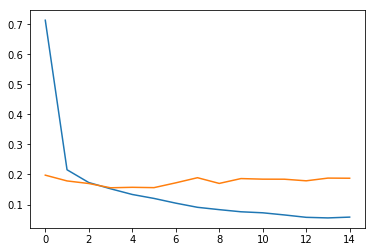

In [25]:
plt.plot([float(v) for v in re.findall(r'train.*loss=(\d+\.\d+)', lines)])
plt.plot([float(v) for v in re.findall(r'dev.*loss=(\d+\.\d+)', lines)])
plt.show()

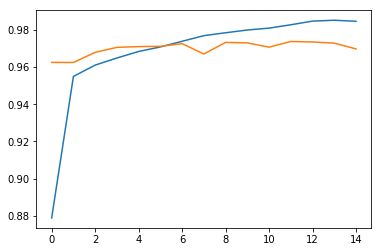

In [26]:
plt.plot([float(v) for v in re.findall(r'train.*accuracy=(\d+\.\d+)', lines)])
plt.plot([float(v) for v in re.findall(r'dev.*accuracy=(\d+\.\d+)', lines)])
plt.show()

In [18]:
shutil.rmtree(
    '../models/simplewiki/el_softmax_2',
    ignore_errors = True)
builder = tf.saved_model.builder.SavedModelBuilder(
    '../models/simplewiki/el_softmax_2')
builder.add_meta_graph_and_variables(
    sess,
    [tf.saved_model.tag_constants.TRAINING])
builder.add_meta_graph(
    [tf.saved_model.tag_constants.SERVING])
builder.save()

INFO:tensorflow:No assets to save.
INFO:tensorflow:No assets to write.
INFO:tensorflow:No assets to save.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: b'../models/simplewiki/el_softmax_2/saved_model.pb'


b'../models/simplewiki/el_softmax_2/saved_model.pb'

# Error Analysis

In [5]:
sess = reset_tf(sess)

In [6]:
_ = tf.saved_model.loader.load(
    sess,
    [tf.saved_model.tag_constants.TRAINING],
    '../models/simplewiki/el_softmax_2')

INFO:tensorflow:Restoring parameters from b'../models/simplewiki/el_softmax_2/variables/variables'


In [8]:
dump_statistics()

parameters for "model/word_embeddings:0": 7680000
parameters for "model/position_embeddings:0": 1296
parameters for "model/attention_with_ff/input/kernel:0": 69632
parameters for "model/attention_with_ff/input/bias:0": 256
parameters for "model/attention_with_ff/input/gamma:0": 256
parameters for "model/attention_with_ff/input/beta:0": 256
parameters for "model/attention_with_ff/layer_0/attention/projection_weights:0": 65536
parameters for "model/attention_with_ff/layer_0/attention/output:0": 65536
parameters for "model/attention_with_ff/layer_0/attention/gamma:0": 256
parameters for "model/attention_with_ff/layer_0/attention/beta:0": 256
parameters for "model/attention_with_ff/layer_0/ff/fc1/kernel:0": 131072
parameters for "model/attention_with_ff/layer_0/ff/fc1/bias:0": 512
parameters for "model/attention_with_ff/layer_0/ff/fc2/kernel:0": 131072
parameters for "model/attention_with_ff/layer_0/ff/fc2/bias:0": 256
parameters for "model/attention_with_ff/layer_0/ff/gamma:0": 256
parame

In [10]:
dataset_iterator = tf.get_default_graph().get_operation_by_name('dataset/MakeIterator')
dataset_filenames = tf.get_default_graph().get_tensor_by_name('dataset/dataset_filenames:0')
training = tf.get_default_graph().get_tensor_by_name('model/training:0')
context_word_ids = tf.get_default_graph().get_tensor_by_name('dataset/context_word_ids:0')
context_positions = tf.get_default_graph().get_tensor_by_name('dataset/Reshape:0')
link_mask = tf.get_default_graph().get_tensor_by_name('dataset/link_mask:0')
target_labels = tf.get_default_graph().get_tensor_by_name('dataset/target_labels:0')
output_labels = tf.get_default_graph().get_tensor_by_name('train/ArgMax:0')

In [11]:
with open('../data/simplewiki/simplewiki-20171103.el_softmax_2.vocab.txt', 'rt') as f:
    vocab = [w.strip() for w in f]

In [12]:
with open('../data/simplewiki/simplewiki-20171103.el_softmax_2.targets.txt', 'rt') as f:
    targets = [t.strip() for t in f]

In [13]:
def compute_negative_examples(filenames, limit = None):
    # initialize dataset iterator
    sess.run(dataset_iterator, feed_dict = {
        dataset_filenames: filenames,
        training: False })
    
    examples = []
    
    while True:
        # compute minibatch
        try:
            (curr_context_word_ids, curr_target_labels, curr_output_labels, curr_link_mask) = sess.run(
                (context_word_ids, target_labels, output_labels, link_mask),
                feed_dict = { training: False })
        except tf.errors.OutOfRangeError:
                break

        # loop through examples
        for c, t, o, l in zip(curr_context_word_ids, curr_target_labels, curr_output_labels, curr_link_mask):
            # skip accurate inferences
            if t == o:
                continue
                
            # stop if limit reached
            if limit and len(examples) >= limit:
                break
            
            # decode context
            words = []
            link_words = []
            for word_id, link_mask_flag in zip(c, l):
                word = vocab[word_id]
                if link_mask_flag:
                    words.append('_%s_' % word)
                    link_words.append(word)
                else:
                    words.append(word)

            # decode example
            examples.append([
                targets[t], # target label
                targets[o], # output label
                ' '.join(link_words), # link
                ' '.join(words) ]) # context
    
    return examples

In [14]:
examples = compute_negative_examples([
    '../data/simplewiki/simplewiki-20171103.el_softmax_2.dev/examples.0000000000.tfrecords.gz',
    '../data/simplewiki/simplewiki-20171103.el_softmax_2.dev/examples.0000010000.tfrecords.gz'])

In [15]:
len(examples)

487

In [16]:
examples[6]

['PRESIDENT OF THE UNITED STATES',
 'PRESIDENT',
 'president',
 'has the second - highest number of people in the state , after st. louis county . it has two county capitals , independence and kansas city . the county was created december 15 , 1826. it was named for _president_ andrew jackson ( elected 1828 ) . <OOB> <OOB> <OOB> <OOB> <OOB> <OOB> <OOB> <OOB> <OOB> <OOB> <OOB> <OOB> <OOB> <OOB> <OOB> <OOB> <OOB> <OOB> <OOB> <OOB> <OOB> <OOB> <OOB> <OOB> <OOB> <OOB> <OOB> <OOB> <OOB> <OOB> <OOB> <OOB> <OOB>']

In [22]:
import csv
with open('/tmp/errors.csv', 'wt') as f:
    writer = csv.writer(f)
    writer.writerow(['target', 'output', 'link', 'context'])
    for example in examples:
        writer.writerow(example)

In [ ]:
# with open('../logs/simplewiki/mediawiki_el_softmax_1.multihead.log.old', 'wt') as f:
#     print(lines)

In [ ]:
# with open('../logs/simplewiki/mediawiki_el_softmax_1.multihead.log', 'rt') as f:
#     lines = '\n'.join([l for l in f])
    
# plt.plot([float(v) for v in re.findall(r'train.*loss=(\d+\.\d+)', lines)], label='train')
# plt.plot([float(v) for v in re.findall(r'dev.*loss=(\d+\.\d+)', lines)], label='dev')
# plt.title('loss')
# plt.legend()
# plt.show()
# plt.plot([float(v) for v in re.findall(r'train.*accuracy=(\d+\.\d+)', lines)], label='train')
# plt.plot([float(v) for v in re.findall(r'dev.*accuracy=(\d+\.\d+)', lines)], label='dev')
# plt.title('accuracy')
# plt.legend()
# plt.show()